In [1]:
%matplotlib inline
import openmc as mc
import numpy as np
import matplotlib.pyplot as plt

import math

import openmc.mgxs as mgxs

## materials (fuel, clad, lbe) 

In [2]:
uranium = mc.Material(1, "depleted uranium")
uranium.add_nuclide('U238', 99.8, 'wo')
uranium.add_nuclide('U235', 0.2, 'wo')
uranium.add_nuclide('U234', 0.001, 'wo')
uranium.deplete = True

zirconium = mc.Material(2, "zirconium")
zirconium.add_element('Zr',1,'wo')

plutonium = mc.Material(3, "plutonium")
plutonium.add_nuclide('Pu238', 3.18, 'wo')
plutonium.add_nuclide('Pu239', 56.35, 'wo')
plutonium.add_nuclide('Pu240', 26.6, 'wo')
plutonium.add_nuclide('Pu241', 8.02, 'wo')
plutonium.add_nuclide('Pu242', 5.83, 'wo')
plutonium.deplete = True

upz = mc.Material.mix_materials([uranium, plutonium, zirconium], [0.8, 0.1, 0.1], 'wo')
upz.set_density('g/cc', 11.88)
upz.temperature = 800

In [3]:
lbe = mc.Material(5, "lead-bismuth-eutectic")

lbe.add_element('Pb', 44.5, 'wo')
lbe.add_element('Bi', 55.5, 'wo')

lbe.set_density('g/cc', 10.3)
lbe.temperature = 620.15

In [4]:
steel = mc.Material(6, "15-15Ti Steel")

steel.add_nuclide('C12', 0.1, 'wo')
steel.add_nuclide('Mn55', 1.49, 'wo')
steel.add_nuclide('Si28', 0.52, 'wo')
steel.add_nuclide('P31', 0.041, 'wo')

steel.add_element('Cr', 15.95, 'wo')
steel.add_element('Ni', 15.40, 'wo')
steel.add_element('B', 0.007, 'wo')
steel.add_element('Mo', 1.2, 'wo')
steel.add_element('Cu', 0.026, 'wo')
steel.add_element('V', 0.036, 'wo')
steel.add_element('Al', 0.023, 'wo')
steel.add_element('Ti', 0.44, 'wo')
steel.add_element('Fe', 64.767, 'wo')

steel.set_density('g/cc', 7.92)
steel.temperature = 750

In [5]:
mats = mc.Materials([upz, lbe, steel])
mats.export_to_xml()

# geometry

In [6]:
ac_top = mc.ZPlane(z0=70, boundary_type='vacuum')
ac_bottom = mc.ZPlane(z0=-70, boundary_type='vacuum')

f_radii = [0.74, 0.76, 0.78]
r_clad_radii = [0.77, 0.79, 0.81]

r_fuel = [mc.ZCylinder(r=ra) for ra in f_radii]
r_clad = [mc.ZCylinder(r=rc) for rc in r_clad_radii]

In [7]:
fuel = [mc.Cell(fill=upz, region=-cyl & +ac_bottom & -ac_top) for cyl in r_fuel]
clad = [mc.Cell(fill=steel, region=+f & -c & +ac_bottom & -ac_top) for f,c in zip(r_fuel,r_clad)]
coolant = [mc.Cell(fill=lbe, region=+c & -ac_top & +ac_bottom) for c in r_clad]
all_coolant_cell = mc.Cell(fill=lbe)

In [8]:
pin_universe = [mc.Universe(cells=[fuel[i],clad[i],coolant[i]], name='pin_for_zone '+str(i+1)) for i in [0,1,2]]
outer_universe = mc.Universe(cells=(all_coolant_cell,))
#outer_universe_for_assembly = mc.Universe(cells=(mc.Cell(fill=lbe, region=mc.model.hexagonal_prism(edge_length=16))))

In [9]:
lattice = [mc.HexLattice(name='assembly lattice:'+str(i+1)) for i in [0,1,2]]
    

In [10]:
for i in [0,1,2]:
    lattice[i].center = (0., 0.)
    lattice[i].pitch = (1.9, )
    lattice[i].outer = outer_universe
    lattice[i].orientation = 'x'
    rings = [[pin_universe[i]]*cir for cir in [24, 18, 12, 6, 1]]
    lattice[i].universes = rings

In [11]:
assem_region = mc.model.hexagonal_prism( edge_length=11.5, orientation='x', boundary_type='transmission')
assembly_cell = [mc.Cell(fill=lattice[i], region= assem_region & -ac_top & +ac_bottom) for i in [0,1,2]]
#outer_assembly_cell = mc.Cell(fill=lbe, region=-ac_top & +ac_bottom)

In [12]:
assembly_universe = [mc.Universe(cells=(assembly_cell[i],)) for i in [0, 1, 2]]


In [13]:
core_lat = mc.HexLattice(name='core_lattice_hex')

core_lat.center = (0., 0.)
core_lat.pitch = (16,)
core_lat.outer = outer_universe


In [14]:
reflective_ring = [outer_universe]*36
ring1 = [assembly_universe[2]]*30

ring2 = [assembly_universe[2]]*2 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]*3 + [outer_universe] +\
    [assembly_universe[2]]

ring3 = [assembly_universe[1]]*18

ring4 = [outer_universe] + [assembly_universe[1]]*5 +\
        [outer_universe] + [assembly_universe[1]]*5

ring5 = [assembly_universe[0]]*6
ring6 = [assembly_universe[0]]
        

In [15]:
core_lat.universes = [reflective_ring,ring1, ring2, ring3, ring4, ring5, ring6]

In [16]:
core_region = mc.model.hexagonal_prism(edge_length=110, orientation='y',boundary_type='vacuum')
root_cell = mc.Cell(fill=core_lat, region=core_region & -ac_top & +ac_bottom)
root_universe = mc.Universe(cells=(root_cell,))

In [17]:
geom = mc.Geometry(root_universe)
geom.export_to_xml()

In [18]:
bounds = [-85, -85, -70, 85, 85, 70]
uniform_dist = mc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
src = mc.Source(space=uniform_dist)

In [19]:
settings = mc.Settings()
settings.source = src
settings.batches = 6
settings.inactive = 5
settings.particles = 2000000
settings.generations_per_batch = 5
settings.temperature = {'method':'interpolation'}
settings.trigger_active = False

settings.output = {'tallies': False}

settings.export_to_xml()

# setting mgxs library

In [20]:
# Instantiate a 100-group EnergyGroups object
energy_groups = mc.mgxs.EnergyGroups()
energy_groups.group_edges = np.logspace(-3, 7.3, 21)

# Instantiate a 1-group EnergyGroups object
one_group = mc.mgxs.EnergyGroups()
one_group.group_edges = np.array([energy_groups.group_edges[0], energy_groups.group_edges[-1]])

# Instantiate delayed groups
delayed_groups = list(range(1,7))

In [21]:
# Instantiate a few different sections
chi_prompt = mgxs.Chi(domain=root_cell, groups=energy_groups, by_nuclide=True, prompt=True)
prompt_nu_fission = mgxs.FissionXS(domain=root_cell, groups=energy_groups, by_nuclide=True, nu=True, prompt=True)
chi_delayed = mgxs.ChiDelayed(domain=root_cell, energy_groups=energy_groups, by_nuclide=True)
delayed_nu_fission = mgxs.DelayedNuFissionXS(domain=root_cell, energy_groups=energy_groups, delayed_groups=delayed_groups, by_nuclide=True)
beta = mgxs.Beta(domain=root_cell, energy_groups=energy_groups, delayed_groups=delayed_groups, by_nuclide=True)
decay_rate = mgxs.DecayRate(domain=root_cell, energy_groups=one_group, delayed_groups=delayed_groups, by_nuclide=True)

chi_prompt.nuclides = ['U235', 'Pu239', 'Pu241']
prompt_nu_fission.nuclides = ['U235', 'Pu239', 'Pu241']
chi_delayed.nuclides = ['U235', 'Pu239', 'Pu241']
delayed_nu_fission.nuclides = ['U235', 'Pu239', 'Pu241']
beta.nuclides = ['U235', 'Pu239', 'Pu241','U238']
decay_rate.nuclides = ['U235', 'Pu239', 'Pu241']

In [22]:
# Instantiate an empty Tallies object
tallies_file = mc.Tallies()

# Add chi-prompt tallies to the tallies file
tallies_file += chi_prompt.tallies.values()

# Add prompt-nu-fission tallies to the tallies file
tallies_file += prompt_nu_fission.tallies.values()

# Add chi-delayed tallies to the tallies file
tallies_file += chi_delayed.tallies.values()

# Add delayed-nu-fission tallies to the tallies file
tallies_file += delayed_nu_fission.tallies.values()

# Add beta tallies to the tallies file
tallies_file += beta.tallies.values()

# Add decay rate tallies to the tallies file
tallies_file += decay_rate.tallies.values()

# Export to "tallies.xml"
tallies_file.export_to_xml()

/home/fuad/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/home/fuad/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/fuad/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/fuad/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)
/home/fuad/miniconda3/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=11.
  warn(msg, IDWarning)


In [23]:
mc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

In [44]:
# Load the last statepoint file
sp = mc.StatePoint('statepoint.16.h5')

In [45]:
# Load the tallies from the statepoint into each MGXS object
chi_prompt.load_from_statepoint(sp)
prompt_nu_fission.load_from_statepoint(sp)
chi_delayed.load_from_statepoint(sp)
delayed_nu_fission.load_from_statepoint(sp)
beta.load_from_statepoint(sp)
decay_rate.load_from_statepoint(sp)

In [46]:
delayed_nu_fission.get_condensed_xs(one_group).get_xs()

array([[[1.69038978e-08, 2.60116997e-07, 5.54013615e-08]],

       [[8.72527182e-08, 1.69400205e-06, 6.88483490e-07]],

       [[8.32990250e-08, 1.28196479e-06, 4.37724851e-07]],

       [[1.86763286e-07, 2.34048224e-06, 1.07200663e-06]],

       [[7.65703103e-08, 1.21910077e-06, 6.06446108e-07]],

       [[3.20750368e-08, 3.68977176e-07, 2.09360598e-07]]])

In [47]:
df = decay_rate.get_pandas_dataframe()
df.head(12)

,cell,delayedgroup,group in,nuclide,mean,std. dev.
0,14,1,1,U235,0.013336,0.000002
1,14,1,1,Pu239,0.013271,0.000001
2,14,1,1,Pu241,0.013599,0.000002
3,14,2,1,U235,0.032739,0.000004
4,14,2,1,Pu239,0.030881,0.000003
5,14,2,1,Pu241,0.029966,0.000004
6,14,3,1,U235,0.120780,0.000015
7,14,3,1,Pu239,0.113370,0.000012
8,14,3,1,Pu241,0.116730,0.000014
9,14,4,1,U235,0.302780,0.000037


In [48]:
beta.export_xs_data(filename='beta', format='excel')

/home/fuad/miniconda3/lib/python3.8/site-packages/openmc/mgxs/mdgxs.py:746: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(filename + '.xls', index=False)


In [50]:
# Get the decay rate data
dr_tally = decay_rate.xs_tally
dr_u235 = dr_tally.get_values(nuclides=['U235']).flatten()
dr_pu239 = dr_tally.get_values(nuclides=['Pu239']).flatten()
dr_pu241 = dr_tally.get_values(nuclides=['Pu241']).flatten()

In [51]:
# Compute the exponential decay of the precursors
time = np.logspace(-3,3)
dr_u235_points = np.exp(-np.outer(dr_u235, time))
dr_pu239_points = np.exp(-np.outer(dr_pu239, time))

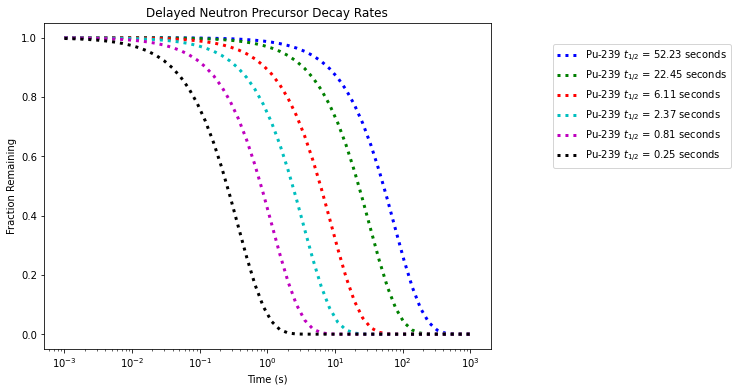

In [60]:
# Create a plot of the fraction of the precursors remaining as a f(time)
colors = ['b', 'g', 'r', 'c', 'm', 'k']
legend = []
fig = plt.figure(figsize=(8,6))
for g,c in enumerate(colors):
    #plt.semilogx(time, dr_u235_points [g,:], color=c, linestyle='--', linewidth=3)
    plt.semilogx(time, dr_pu239_points[g,:], color=c, linestyle=':' , linewidth=3)
    #legend.append('U-235 $t_{1/2}$ = ' + '{0:1.2f} seconds'.format(np.log(2) / dr_u235[g]))
    legend.append('Pu-239 $t_{1/2}$ = ' + '{0:1.2f} seconds'.format(np.log(2) / dr_pu239[g]))

plt.title('Delayed Neutron Precursor Decay Rates')
plt.xlabel('Time (s)')
plt.ylabel('Fraction Remaining')
plt.legend(legend, loc=1, bbox_to_anchor=(1.55, 0.95))
plt.savefig('precursor_decay_rates.png')

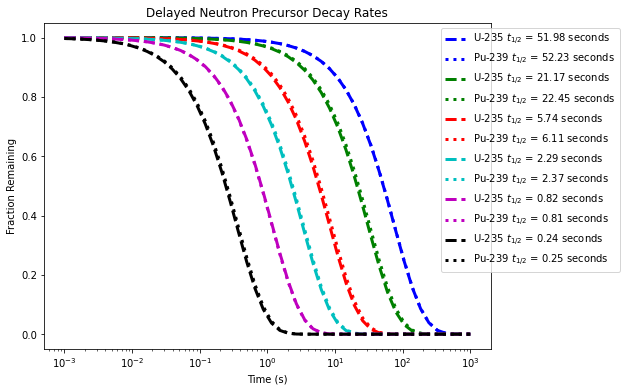

In [79]:
# Create a plot of the fraction of the precursors remaining as a f(time)
colors = ['b', 'g', 'r', 'c', 'm', 'k']
legend = []
fig = plt.figure(figsize=(8,6))
for g,c in enumerate(colors):
    plt.semilogx(time, dr_u235_points [g,:], color=c, linestyle='--', linewidth=3)
    plt.semilogx(time, dr_pu239_points[g,:], color=c, linestyle=':' , linewidth=3)
    legend.append('U-235 $t_{1/2}$ = ' + '{0:1.2f} seconds'.format(np.log(2) / dr_u235[g]))
    legend.append('Pu-239 $t_{1/2}$ = ' + '{0:1.2f} seconds'.format(np.log(2) / dr_pu239[g]))

plt.title('Delayed Neutron Precursor Decay Rates')
plt.xlabel('Time (s)')
plt.ylabel('Fraction Remaining')
plt.legend(legend, loc=1, bbox_to_anchor=(1.3, 1))
plt.savefig('precursor_decay_rates_all.jpg')

In [53]:
# Use tally arithmetic to compute the precursor concentrations
precursor_conc = beta.get_condensed_xs(one_group).xs_tally.summation(filter_type=mc.EnergyFilter, remove_filter=True) * \
    delayed_nu_fission.get_condensed_xs(one_group).xs_tally.summation(filter_type=mc.EnergyFilter, remove_filter=True) / \
    decay_rate.xs_tally.summation(filter_type=mc.EnergyFilter, remove_filter=True)

# Get the Pandas DataFrames for inspection
precursor_conc.get_pandas_dataframe()

,cell,delayedgroup,nuclide,score,mean,std. dev.
0,14,1,((U235 * U235) / U235),(((delayed-nu-fission / nu-fission) * (delayed...,2.977814e-10,5.854232e-14
1,14,1,((U235 * U235) / Pu239),(((delayed-nu-fission / nu-fission) * (delayed...,2.992399e-10,5.571162e-14
2,14,1,((U235 * U235) / Pu241),(((delayed-nu-fission / nu-fission) * (delayed...,2.920224e-10,5.740901e-14
3,14,1,((U235 * Pu239) / U235),(((delayed-nu-fission / nu-fission) * (delayed...,4.582256e-09,8.900040e-13
4,14,1,((U235 * Pu239) / Pu239),(((delayed-nu-fission / nu-fission) * (delayed...,4.604700e-09,8.457742e-13
...,...,...,...,...,...,...
211,14,6,((U238 * Pu239) / Pu239),(((delayed-nu-fission / nu-fission) * (delayed...,2.192032e-10,5.193832e-14
212,14,6,((U238 * Pu239) / Pu241),(((delayed-nu-fission / nu-fission) * (delayed...,1.992670e-10,4.886204e-14
213,14,6,((U238 * Pu241) / U235),(((delayed-nu-fission / nu-fission) * (delayed...,1.190024e-10,2.940793e-14
214,14,6,((U238 * Pu241) / Pu239),(((delayed-nu-fission / nu-fission) * (delayed...,1.243777e-10,2.971583e-14


In [68]:
energy_filter = [f for f in beta.xs_tally.filters if type(f) is mc.EnergyFilter]
beta_integrated = beta.get_condensed_xs(one_group).xs_tally.summation(filter_type=mc.EnergyFilter, remove_filter=True)
beta_u235  = beta_integrated.get_values(nuclides=['U235'])
beta_pu239 = beta_integrated.get_values(nuclides=['Pu239'])
beta_pu241 = beta_integrated.get_values(nuclides=['Pu241'])
beta_u238 = beta_integrated.get_values(nuclides=['U238'])

Beta (U-235) : 0.006711 +/- 0.000000
Beta (Pu-239): 0.002184 +/- 0.000000


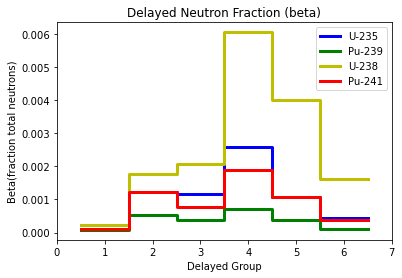

In [69]:
# Reshape the betas
beta_u235.shape = (beta_u235.shape[0])
beta_pu239.shape = (beta_pu239.shape[0])
beta_pu241.shape = (beta_pu241.shape[0])
beta_u238.shape = (beta_u238.shape[0])

df = beta_integrated.summation(filter_type=mc.DelayedGroupFilter, remove_filter=True).get_pandas_dataframe()
print('Beta (U-235) : {:.6f} +/- {:.6f}'.format(df[df['nuclide'] == 'U235']['mean'][0], df[df['nuclide'] == 'U235']['std. dev.'][0]))
print('Beta (Pu-239): {:.6f} +/- {:.6f}'.format(df[df['nuclide'] == 'Pu239']['mean'][1], df[df['nuclide'] == 'Pu239']['std. dev.'][1]))
#print('Beta (U-238) : {:.6f} +/- {:.6f}'.format(df[df['nuclide'] == 'U238']['mean'][0], df[df['nuclide'] == 'U238']['std. dev.'][0]))
#print('Beta (Pu-241): {:.6f} +/- {:.6f}'.format(df[df['nuclide'] == 'Pu241']['mean'][0], df[df['nuclide'] == 'Pu241']['std. dev.'][1]))

beta_u235 = np.append(beta_u235[0], beta_u235)
beta_pu239 = np.append(beta_pu239[0], beta_pu239)
beta_u238 = np.append(beta_u238[0], beta_u238)
beta_pu241 = np.append(beta_pu241[0], beta_pu241)

# Create a step plot for the MGXS
plt.plot(np.arange(0.5, 7.5, 1), beta_u235, drawstyle='steps', color='b', linewidth=3)
plt.plot(np.arange(0.5, 7.5, 1), beta_pu239, drawstyle='steps', color='g', linewidth=3)
plt.plot(np.arange(0.5, 7.5, 1), beta_u238, drawstyle='steps', color='y', linewidth=3)
plt.plot(np.arange(0.5, 7.5, 1), beta_pu241, drawstyle='steps', color='r', linewidth=3)


plt.title('Delayed Neutron Fraction (beta)')
plt.xlabel('Delayed Group')
plt.ylabel('Beta(fraction total neutrons)')
plt.legend(['U-235', 'Pu-239', 'U-238', 'Pu-241'])
plt.xlim([0,7])
plt.savefig('beta_6groups.jpg')

## We can also plot the energy spectrum for fission emission of prompt and delayed neutrons.

(1000.0, 20000000.0)

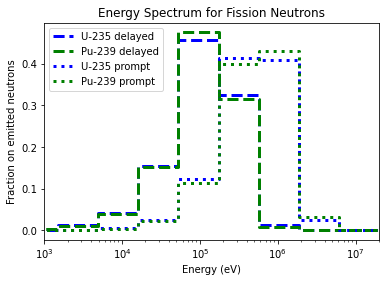

In [56]:
chi_d_u235  = np.squeeze(chi_delayed.get_xs(nuclides=['U235'], order_groups='decreasing'))
chi_d_pu239 = np.squeeze(chi_delayed.get_xs(nuclides=['Pu239'], order_groups='decreasing'))
chi_p_u235  = np.squeeze(chi_prompt.get_xs(nuclides=['U235'], order_groups='decreasing'))
chi_p_pu239 = np.squeeze(chi_prompt.get_xs(nuclides=['Pu239'], order_groups='decreasing'))

chi_d_u235  = np.append(chi_d_u235 , chi_d_u235[0])
chi_d_pu239 = np.append(chi_d_pu239, chi_d_pu239[0])
chi_p_u235  = np.append(chi_p_u235 , chi_p_u235[0])
chi_p_pu239 = np.append(chi_p_pu239, chi_p_pu239[0])

# Create a step plot for the MGXS
plt.semilogx(energy_groups.group_edges, chi_d_u235 , drawstyle='steps', color='b', linestyle='--', linewidth=3)
plt.semilogx(energy_groups.group_edges, chi_d_pu239, drawstyle='steps', color='g', linestyle='--', linewidth=3)
plt.semilogx(energy_groups.group_edges, chi_p_u235 , drawstyle='steps', color='b', linestyle=':', linewidth=3)
plt.semilogx(energy_groups.group_edges, chi_p_pu239, drawstyle='steps', color='g', linestyle=':', linewidth=3)

plt.title('Energy Spectrum for Fission Neutrons')
plt.xlabel('Energy (eV)')
plt.ylabel('Fraction on emitted neutrons')
plt.legend(['U-235 delayed', 'Pu-239 delayed', 'U-235 prompt', 'Pu-239 prompt'],loc=2)
plt.xlim(1.0e3, 20.0e6)

In [57]:
energy_groups.group_edges

array([1.00000000e-03, 3.27340695e-03, 1.07151931e-02, 3.50751874e-02,
       1.14815362e-01, 3.75837404e-01, 1.23026877e+00, 4.02717034e+00,
       1.31825674e+01, 4.31519077e+01, 1.41253754e+02, 4.62381021e+02,
       1.51356125e+03, 4.95450191e+03, 1.62181010e+04, 5.30884444e+04,
       1.73780083e+05, 5.68852931e+05, 1.86208714e+06, 6.09536897e+06,
       1.99526231e+07])